# TOV Emulator to train a NN to predict just MASS of a Neutron Star from a Neuclear EOS

### <div style= 'color: goldenrod'> Import all the required modules

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
from numpy import pi as pi
from scipy.integrate import odeint
import torch
import torch.nn as nn
import torch.optim as optim
import time # to meaasure execution time of code blocks
from torch.utils.data import TensorDataset, DataLoader


# Custom modules
import eos # generates EOS tables. Returns energy density, pressure, etc. for given set of EOS parameters. 
import tov # solves TOV equations for neutron star structure (mass, radius) given an EOS.
import tov_tide # solves TOV equations including tidal deformability calculations, for neutron star tidal effects in binaries.


%matplotlib widget

### <div style= 'color: goldenrod'> Define the following functions:
$EoS(\theta)$:
Generate the energy density and pressure arrays for a given EOS parameter set.

$find\_first\_maxima$:
Find first local maxima (to get NS mass)

$get\_MR\_pc$:
Solve TOV equations to get mass-radius points for an array of central pressures.

$get\_MRL\_pc$:
Solve TOV equations to get mass, radius and tidal deformability points for an array of central pressures.

In [2]:
dkm = 1.3234e-6 # conversion of energy density and pressure from Mev/fm^3 to km^-2
conv = 197.33**3 # MeV/fm3 is roughly h_bar * c in natural units
pcmin = 1.33e-6 # Fiducial minimum central pressure used when generating neutron star sequences
                # Ensures TOV solver starts with a non-zero pressure 


def EoS(θ):
    """
    Generate the energy density and pressure arrays for a given EOS parameter set.
    Returns Energy and pressure array given given eos parameters and if eos is not montonic returns nan.
    
    Parameters:
    ----------
    θ = [L0, Ksym]: parameters of the nuclear EOS.
            
            L0: slope of symmetry energy. Controls how neutron-rich matter pressure grows with density.
            Ksym: curvature of symmetry energy. Determines how “stiff” the EOS is for neutron-rich matter at higher densities.
    
    Returns:
    -------
    nb: baryon number density array
    ener: energy density at each density point array
    pres: pressure at each density point array
    cs: speed of sound array
    icc: flag if EOS is causal or monotonic

    """
    L0, Ksym = θ[0], θ[1]
    # Calling the eos.eos module
    index, nb, pressure, energy, cs, icc = eos.eos(L0, Ksym, 1.6, 3.0, 6.2, 3.7, 2.4, 2.6)
    # Truncate arrays up to index-1 to ensure valid, monotonic EOS.
    nb = nb[0:index-1] 
    pressure = pressure[0:index-1]
    energy = energy[0:index-1]
    cs = cs[0:index-1]
    # Converts pressure and energy to km^-2 units
    pres = pressure * dkm
    ener = energy * dkm
    return ener, pres, nb, cs, icc

################################################################################

def get_MR_pc(θ, pc):
    """
    Solve TOV equations to get mass-radius points for an array of central pressures.

    Parameters:
    ----------
    θ: [L0, Ksym] EOS parameters
    pc: array of entral pressures

    Returns:
    -------
    M: List of Masses
    R: List of Radiuses corresponding to each central pressure

    """
    M=[]
    R=[]
    for i in pc:
        L0, Ksym = θ[0], θ[1]
        # Calling the eos.eos module
        index, nb, pressure, energy, cs, icc = eos.eos(L0, Ksym, 1.6, 3.0, 6.2, 3.7, 2.4, 2.6)
        pressure = pressure[0:index-1]
        energy = energy[0:index-1]
        pres = pressure * dkm
        ener = energy * dkm
        # Calling the tov.tov module
        m, r = tov.tov(ener, pres, [i])
        M.append(m)
        R.append(r)
    return M, R
    
################################################################################

def get_MRL_pc(θ, pc):
    """
    Solve TOV equations to get mass, radius and tidal deformability points for an array of central pressures.

    Parameters:
    ----------
    θ: [L0, Ksym] EOS parameters
    pc: array of central pressures

    Returns:
    -------
    M: List of Masses
    R: List of Radiuses 
    L: List of Tidal deformabilities corresponding to each central pressure
    """
    M=[]
    R=[]
    L=[]
    for i in pc:
        L0, Ksym = θ[0] ,θ[1]
        # Calling the eos.eos module
        index, nb, pressure, energy, cs, icc = eos.eos(L0, Ksym, 1.6, 3.0, 6.2, 3.7, 2.4, 2.6)
        pressure = pressure[0:index-1]
        energy = energy[0:index-1]
        pres = pressure * dkm
        ener = energy * dkm
        # Calling the tov_tide.tov_tide module
        m, r, td = tov_tide.tov_tide(ener, pres, [i])
        M.append(m)
        R.append(r)
        L.append(td)
    return M, R, L

################################################################################

def find_first_maxima(arr):
    """
    Identify the first peak in a 1D array (used to find maximum neutron star mass).
    Loops through array to check if an element is larger than its neighbors → first local maximum.
    If no local maxima found, returns global maximum as fallback.

    Parameters:
    ----------
    arr: mass array

    Returns:
    -------
    max_index: index of the first maxima
    arr[max_index]: mass value of the first maxima

    """
    for i in range(1, len(arr) - 1):
        if arr[i] > arr[i - 1] and arr[i] > arr[i + 1]:
            return i, arr[i]  # Return the index and the value of the first maxima
    max_index = np.argmax(arr)
    return max_index, arr[max_index]

### <div style= 'color: yellow'> Load the generated dataset, normalizing it and splitting into training and validation datasets

In [3]:
import pandas as pd
import re

num_samples = 10000 #############################################################

# Load dataset saved with np.savez
dataset_name = f"EOS_dataset_{num_samples}samples.npz"
dataset_loc = "/home/kay/ML-for-Neutron-Stars/COMMA_emulator/Outputs-Kay/Datasets/"
data = np.load(dataset_loc+dataset_name)

# Extract columns
log_pc_samples = data['log_pc_samples']     # shape: (N,)
valid_EOS_params = data['valid_EOS_params'] # shape: (N, 2)
MRL_data = data['MRL_data']                 # shape: (N, 3)

# Visualizing the dataset
df = pd.DataFrame(
    np.column_stack([log_pc_samples, valid_EOS_params, MRL_data]),
    columns=["log_pc", "L", "Ksym", "Mass", "Radius", "TidalDeformability"]
)
n = int(re.search(r"\d+", dataset_name).group())
print(f"Dataset preview with {n} samples:")
print(df.head(10))  # nicely formatted table of the first 10 values

# Prepare X (features) and y (targets)
X_eos = torch.tensor(np.column_stack([log_pc_samples, valid_EOS_params]), dtype=torch.float32)  # pc, L, Ksym
y_eos = torch.tensor(MRL_data[:, :1], dtype=torch.float32)  # Mass (target)

# Normalize the dataset
X_eos_mean, X_eos_std = X_eos.mean(dim=0), X_eos.std(dim=0)
y_eos_mean, y_eos_std = y_eos.mean(dim=0), y_eos.std(dim=0)
X_eos_norm = (X_eos - X_eos_mean) / X_eos_std
y_eos_norm = (y_eos - y_eos_mean) / y_eos_std

# Split into training and validation sets
train_size = int(0.8 * len(X_eos_norm))
X_eos_train, X_eos_val = X_eos_norm[:train_size], X_eos_norm[train_size:]
y_eos_train, y_eos_val = y_eos_norm[:train_size], y_eos_norm[train_size:]

# Convert data to PyTorch tensors
X_eos_train, y_eos_train = X_eos_train.view(-1, 3), y_eos_train.view(-1, 1)
X_eos_val, y_eos_val = X_eos_val.view(-1, 3), y_eos_val.view(-1, 1)

Dataset preview with 10000 samples:
     log_pc          L      Ksym      Mass     Radius  TidalDeformability
0 -5.876148  68.187008  65.22748  0.101835  58.859709        1.286419e+09
1 -5.815726  68.187008  65.22748  0.109677  40.496606        2.374690e+08
2 -5.755304  68.187008  65.22748  0.119728  30.928258        8.886637e+07
3 -5.694882  68.187008  65.22748  0.131926  25.289924        4.466926e+07
4 -5.634460  68.187008  65.22748  0.146323  21.687515        2.502699e+07
5 -5.574038  68.187008  65.22748  0.163038  19.254424        1.464071e+07
6 -5.513616  68.187008  65.22748  0.182161  17.550100        8.737624e+06
7 -5.453194  68.187008  65.22748  0.203868  16.321324        5.278593e+06
8 -5.392772  68.187008  65.22748  0.228328  15.418891        3.222759e+06
9 -5.332350  68.187008  65.22748  0.255689  14.748779        1.975203e+06


### <div style= 'color: yellow'> Defining and training the NN

In [4]:
# Set model number for saving
Model_num = "Mass_Model9" ###########################################################

In [5]:
# Define Neural Network for EOS predictions
class HybridPP_EOS_NN(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=100, output_dim=1): #############
        super(HybridPP_EOS_NN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc3 = nn.Linear(hidden_dim//2, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1) # Dropout layer for regularization

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)

Epoch [100/10000],
              Training Loss: 0.2323,
              Validation Loss: 0.2228
Epoch [200/10000],
              Training Loss: 0.0537,
              Validation Loss: 0.0423
Epoch [300/10000],
              Training Loss: 0.0240,
              Validation Loss: 0.0131
Epoch [400/10000],
              Training Loss: 0.0182,
              Validation Loss: 0.0079
Epoch [500/10000],
              Training Loss: 0.0162,
              Validation Loss: 0.0062
Epoch [600/10000],
              Training Loss: 0.0150,
              Validation Loss: 0.0054
Epoch [700/10000],
              Training Loss: 0.0141,
              Validation Loss: 0.0047
Epoch [800/10000],
              Training Loss: 0.0132,
              Validation Loss: 0.0042
Epoch [900/10000],
              Training Loss: 0.0125,
              Validation Loss: 0.0038
Epoch [1000/10000],
              Training Loss: 0.0120,
              Validation Loss: 0.0034
Epoch [1100/10000],
              Training Loss: 0.0114,
  

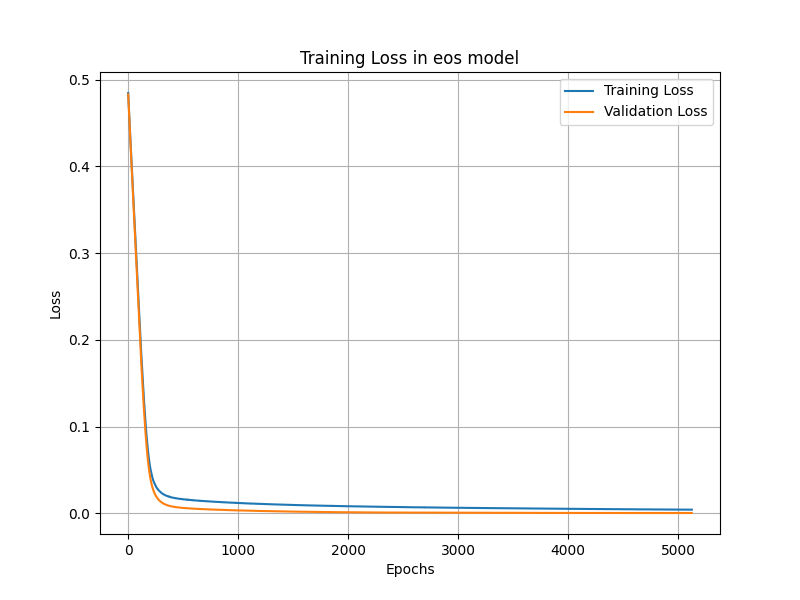

In [ ]:
# Initialize and train the model
model_eos = HybridPP_EOS_NN()
criterion = nn.HuberLoss(delta=1.0)
optimizer = optim.Adam(model_eos.parameters(), lr=0.0001) ######################

start_time = time.time()

epochs = 10000 #################################################################
training_losses = []
val_losses = []

best_val_loss = float('inf')
patience = 200  # Number of epochs to wait for improvement before stopping
patience_counter = 0

# # Batching the data
# batch_size = 16  ###############################################################

# train_dataset = TensorDataset(X_eos_train, y_eos_train)
# val_dataset = TensorDataset(X_eos_val, y_eos_val)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size)

# for epoch in range(epochs):
#     model_eos.train()
#     epoch_train_loss = 0
#     for X_batch, y_batch in train_loader:
#         optimizer.zero_grad()
#         outputs = model_eos(X_batch)
#         loss = criterion(outputs, y_batch)
#         loss.backward()
#         optimizer.step()
#         epoch_train_loss += loss.item() * X_batch.size(0)
#     training_losses.append(epoch_train_loss / len(train_loader.dataset))

#     # Validation
#     model_eos.eval()
#     epoch_val_loss = 0
#     with torch.no_grad():
#         for X_batch, y_batch in val_loader:
#             val_outputs = model_eos(X_batch)
#             val_loss = criterion(val_outputs, y_batch)
#             epoch_val_loss += val_loss.item() * X_batch.size(0)
#     val_losses.append(epoch_val_loss / len(val_loader.dataset))

# Without batching (original code)
for epoch in range(epochs):
    # Training
    model_eos.train() # Training mode
    optimizer.zero_grad() # Erase the record of gradients
    outputs = model_eos(X_eos_train) # Forward pass
    loss = criterion(outputs, y_eos_train) # Compute training loss
    loss.backward() # Backward propogate the training loss
    optimizer.step()
    training_losses.append(loss.item())

    # Validation
    model_eos.eval() # Validation mode
    with torch.no_grad():
        val_outputs = model_eos(X_eos_val)
        val_loss = criterion(val_outputs, y_eos_val)
        val_losses.append(val_loss.item())

    # Early stopping check
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        patience_counter = 0
        # Save the best model weights
        best_model_state = model_eos.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Print progress every 100 epochs
    if (epoch + 1) % 100 == 0: 
        print(f"""Epoch [{epoch + 1}/{epochs}],
              Training Loss: {loss.item():.4f},
              Validation Loss: {val_loss.item():.4f}""")

end_time = time.time()
training_time = end_time - start_time

# Restore best model
model_eos.load_state_dict(best_model_state)
print(f"Training finished. Best validation loss: {best_val_loss:.4f}")

# Plot Training Loss
plt.figure(figsize=(8, 6))
plt.plot(training_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss in eos model")
plt.grid()

fig_loc = "/home/kay/ML-for-Neutron-Stars/COMMA_emulator/Outputs-Kay/Mass_Models/"
fig_name = f"{Model_num}_Losses.png"
plt.savefig(fig_loc+fig_name, dpi=300, bbox_inches='tight')

plt.show()

### <div style= 'color: goldenrod'> Save trained model

In [7]:
# Save trained model
network_loc = "/home/kay/ML-for-Neutron-Stars/COMMA_emulator/Outputs-Kay/Mass_Models/"
network_name = f"{Model_num}_hybridPP_nn.pth"
torch.save(model_eos.state_dict(), network_loc+network_name)

### <div style= 'color: goldenrod'> Save model details to a text file

In [8]:
file_loc = "/home/kay/ML-for-Neutron-Stars/COMMA_emulator/Outputs-Kay/Mass_Models/"
file_name = Model_num+"_details.txt"

with open(file_loc + file_name, "w") as f:
    f.write(f"{Model_num} DETAILS\n\n")
    f.write("Number of dimensions:\n")
    f.write(f"input_dims: {model_eos.fc1.in_features}\n")
    f.write(f"hidden_dims: {model_eos.fc1.out_features}\n")
    f.write(f"output_dims: {model_eos.fc3.out_features}\n\n")
    f.write(f"Number of Hidden Layers: {len(list(model_eos.children()))//2}\n")
    f.write(f"Number of samples: {num_samples}\n\n")
    f.write(f"epochs: {epochs}\n\n")
    f.write(f"delta of criterion: {criterion.delta}\n\n")
    f.write(f"optimizer: Adam\n\n")
    f.write(f"learning rate: {optimizer.param_groups[0]['lr']}\n\n")
    f.write(f"Training stopped at epoch: {epoch+1}\n")
    f.write(f"training_time_seconds: {training_time:.2f}\n")
    f.write(f"Best validation loss: {best_val_loss:.4f}\n\n")


### <div style= 'color: yellow'>Model Evaluation and comparison on Testing (unseen) data

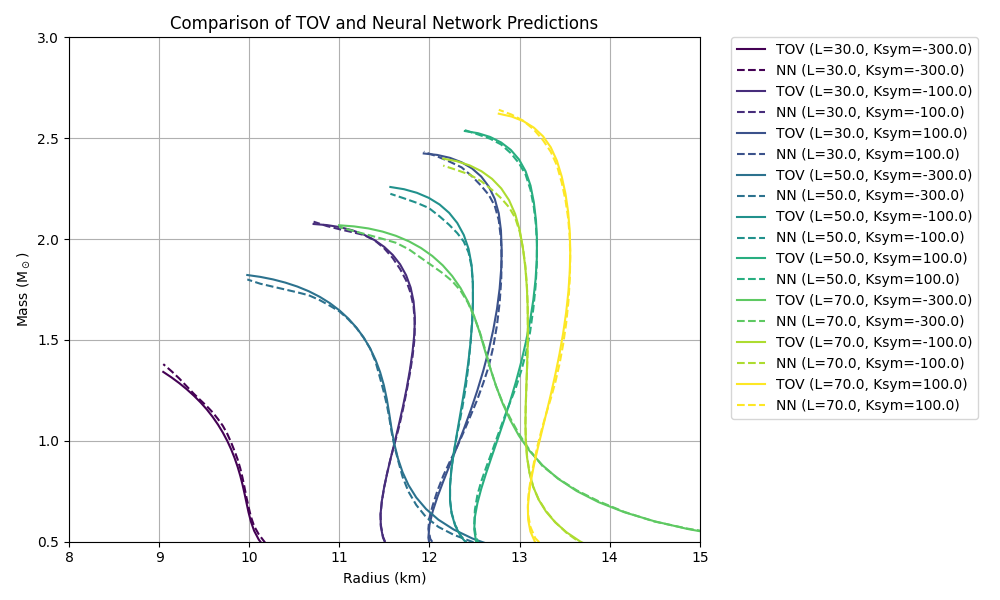

In [9]:
num_points = 50
# Prepare ranges for L and Ksym
L_values = [30., 50., 70.]  
Ksym_values = [-300., -100., 100.]  

# Initialize lists to store results
predicted_mass = []

original_mass = []
original_radius = []

# Iterate over all L and Ksym values
for L in L_values:
    for Ksym in Ksym_values:
        ee, pp, nb, cs, icc = EoS([L, Ksym])
        # Check conditions
        if icc == 0 and max(pp) > pcmin:
            # Create pressure grid
            pc_array = np.logspace(np.log10(pcmin), np.log10(max(pp)), num_points)
            
            # Calculate original mass and radius using TOV
            M_orig, R_orig = get_MR_pc([L, Ksym], pc_array)

            # Convert to NumPy arrays for element-wise operations
            M_orig = np.array(M_orig)
            R_orig = np.array(R_orig)

            # Find first maxima in mass array
            j, mmax = find_first_maxima(M_orig) # mmax is the maximum mass
        
            # Slice and convert to log10
            pc_array = pc_array[:j]
            log_pc_array = np.log10(pc_array)
            M_orig = M_orig[:j]
            R_orig = R_orig[:j]

            # Prepare input for each pc point: [log_pc, L, Ksym]
            input_array = np.column_stack([
                            log_pc_array,
                            np.full_like(log_pc_array, L),
                                np.full_like(log_pc_array, Ksym)
                                            ])
            
            input_tensor = torch.tensor(input_array, dtype=torch.float32)
            
            # Normalize the input data using the training mean and std
            input_norm = (input_tensor - X_eos_mean) / X_eos_std
            
            # Make predictions with the trained model
            with torch.no_grad():  
                prediction = model_eos(input_norm)
            
            # Convert the prediction tensor to NumPy and denormalize the predicted mass and radius
            # Get all predictions
            prediction_np = prediction.detach().numpy()  # shape: (N, 2)

            # Denormalize each column
            mass_pred = prediction_np[:, 0] * y_eos_std[0].item() + y_eos_mean[0].item()

            # After iterating over pc, store the results for each kappa, gamma pair
            predicted_mass.append(mass_pred)
            original_mass.append(M_orig)
            original_radius.append(R_orig)

plt.figure(figsize=(10, 6))

# Create a color map
colors = plt.cm.viridis(np.linspace(0, 1, len(L_values) * len(Ksym_values)))

# Iterate and assign the same color to TOV and NN prediction
for i, (L, Ksym) in enumerate([(k, g) for k in L_values for g in Ksym_values]):
    color = colors[i]
    plt.plot(original_radius[i], original_mass[i], label=f"TOV (L={L}, Ksym={Ksym})", linestyle='-', color=color)
    plt.plot(original_radius[i], predicted_mass[i], label=f"NN (L={L}, Ksym={Ksym})", linestyle='--', color=color)

plt.xlabel("Radius (km)")
plt.ylabel("Mass (M$_\odot$)")
plt.xlim(8, 15)
plt.ylim(0.5, 3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Comparison of TOV and Neural Network Predictions")
plt.grid()
plt.tight_layout()

fig_loc = "/home/kay/ML-for-Neutron-Stars/COMMA_emulator/Outputs-Kay/Mass_Models/"
fig_name = f"{Model_num}_Testing_accuracy.png"
plt.savefig(fig_loc+fig_name, dpi=300, bbox_inches='tight')

plt.show()

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def regression_metrics(y_true, y_pred):
    """
    Compute common regression metrics for comparing predictions with true values.
    
    Parameters:
        y_true (array-like): Ground truth values
        y_pred (array-like): Predicted values
    
    Returns:
        dict: Dictionary containing MAE, MSE, RMSE, and R²
    """

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    return {
        "MAE": np.round(mae,2),
        "MSE": np.round(mse,2),
        "RMSE": rmse,
        "R^2": np.round(r2,2),
    }

In [11]:
# Regression metrics for mass
import json
original_mass_flat=np.concatenate (original_mass).astype(float)
predicted_mass_flat=np.concatenate(predicted_mass).astype(float)
results = regression_metrics(original_mass_flat, predicted_mass_flat)
print(json.dumps(results, indent = 4))

{
    "MAE": 0.02,
    "MSE": 0.0,
    "RMSE": 0.026846386879384673,
    "R^2": 1.0
}
